# **UNSW-NB15 Dataset - Flow Level data**

**1. Import data**

In [ ]:
import csv
import pandas as pd

df = pd.read_csv("nb15_tmlcn.csv") # Flow level data
df.head()

,flowid,sport,dsport,timestamp,totalHeaderSize,max_pkt_size,mean_pkt_size,attack_cat,Label
0,2931,62762,56430,2015-02-18 00:23:27.760103,256,64,64.0,BENIGN,0
1,14190,62708,179,2015-02-18 00:23:29.218521,256,64,64.0,BENIGN,0
2,10577,61809,161,2015-02-18 00:23:33.347124,88,85,85.0,BENIGN,0
3,14226,62969,179,2015-02-18 00:23:35.908011,256,64,64.0,BENIGN,0
4,12332,32473,80,2015-02-18 00:23:36.650797,256,64,64.0,BENIGN,0


In [ ]:
df['attack_cat'].value_counts()

,count
attack_cat,
BENIGN,40550
Exploits,4033
Fuzzers,2914
Generic,593
DoS,569


**2. Visualize attack timelines**

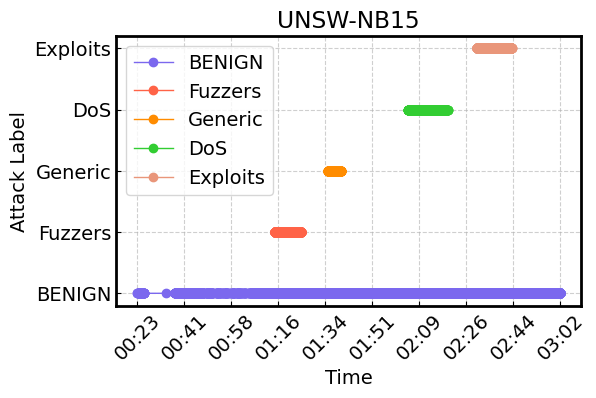

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Drop rows with missing Timestamp values
df = df.dropna(subset=['timestamp'])

# Convert 'timestamp' column to datetime format if it is not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort the DataFrame by 'Timestamp'
df = df.sort_values('timestamp')

# Get unique attack categories
attack_categories = df['attack_cat'].unique()

# Define the colors you want to use
custom_colors = ['mediumslateblue', 'tomato', 'darkorange', 'limegreen', 'darksalmon']

# Plotting
plt.figure(figsize=(6, 3.5), linewidth=2)

plt.rcParams.update({'font.size': 14})

# Plot instances for each attack category with custom colors
for category, color in zip(attack_categories, custom_colors):
    category_data = df[df['attack_cat'] == category]
    plt.plot(category_data['timestamp'], category_data['attack_cat'], marker='o', linestyle='-', label=category, linewidth=1, color=color)

plt.xlabel('Time')
plt.ylabel('Attack Label')

# Calculate the positions of the x-axis ticks (showing only 10 ticks)
tick_count = 10

# Calculate the time range (min and max timestamps)
min_time = df['timestamp'].min()
max_time = df['timestamp'].max()

# Calculate evenly spaced timestamps for the ticks
tick_timestamps = np.linspace(min_time.timestamp(), max_time.timestamp(), tick_count)

# Convert tick_timestamps back to Timestamp objects
tick_timestamps = [pd.Timestamp.fromtimestamp(ts) for ts in tick_timestamps]

# Format the tick labels to display both date and time
tick_labels = [ts.strftime('%H:%M') for ts in tick_timestamps]

plt.xticks(tick_timestamps, tick_labels, rotation=45)

# Increase the border width for spines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set the desired border width
    spine.set_color('black')

# Set ticks inside the plot
ax.tick_params(axis='both', direction='in', which='both', bottom=True, top=False, left=True, right=False)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
#plt.title('Attacking Traffic Timeline')
plt.title("UNSW-NB15")
plt.show()

In [ ]:
df.head()

,flowid,sport,dsport,timestamp,totalHeaderSize,max_pkt_size,mean_pkt_size,attack_cat,Label
0,2931,62762,56430,2015-02-18 00:23:27.760103,256,64,64.0,BENIGN,0
1,14190,62708,179,2015-02-18 00:23:29.218521,256,64,64.0,BENIGN,0
2,10577,61809,161,2015-02-18 00:23:33.347124,88,85,85.0,BENIGN,0
3,14226,62969,179,2015-02-18 00:23:35.908011,256,64,64.0,BENIGN,0
4,12332,32473,80,2015-02-18 00:23:36.650797,256,64,64.0,BENIGN,0


**3.  Draw change in data distribution**

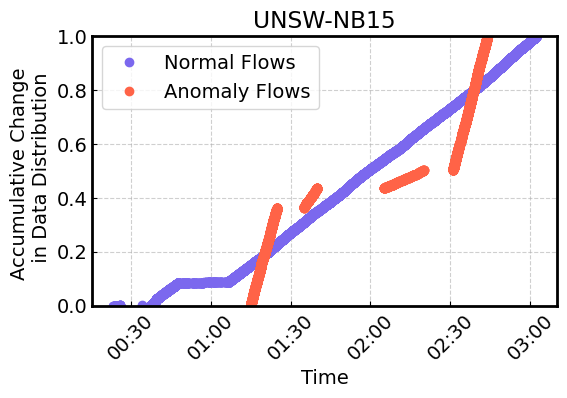

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

# Convert timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Convert selected columns to numeric (if not already)
numeric_columns = ['sport', 'dsport', 'totalHeaderSize', 'max_pkt_size', 'mean_pkt_size']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values after conversion
df = df.dropna(subset=numeric_columns)

# Compute cumulative sum for each class
cumulative_df = df.groupby(['timestamp', 'Label'])[numeric_columns].sum()
cumulative_df = cumulative_df.groupby(level=1).cumsum().reset_index()

# Sum values for each class
sum_df = cumulative_df.groupby('Label')[numeric_columns].sum().reset_index()

# Normalize values for better visualization
normalized_df = sum_df.copy()
normalized_df[numeric_columns] = normalized_df[numeric_columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Create figure
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.rcParams.update({'font.size': 14})

# Define colors
colors = ['mediumslateblue', 'tomato']

# Plot data for each class
for label, color in zip(normalized_df['Label'], colors):
    label_df = cumulative_df[cumulative_df['Label'] == label]

    # Combine values from all numeric columns
    combined_values = label_df[numeric_columns].sum(axis=1)

    # Normalize values
    normalized_combined_values = (combined_values - combined_values.min()) / (combined_values.max() - combined_values.min())

    # Legend labels
    legend_label = 'Normal Flows' if label == 0 else 'Anomaly Flows'

    ax.plot(label_df['timestamp'], normalized_combined_values, label=legend_label, color=color, linewidth=2, marker='o', linestyle='')

# Labels
ax.set_xlabel('Time')
ax.set_ylabel('Accumulative Change \n in Data Distribution')
ax.set_ylim(0, 1)

# **Fix X-Axis Overlap Issues**
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjust tick spacing
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format time
plt.xticks(rotation=45)  # Rotate for readability

# Add legend
ax.legend()

# Add grid
ax.grid(True, linestyle='--', alpha=0.6)

# Customize plot border width
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')

# Set tick direction inside
ax.tick_params(axis='both', direction='in')

# Set title
plt.title("UNSW-NB15")

# Show plot
plt.show()


**4. Preprocessing for model training**

In [ ]:
# Drop unnecesary columns
columns_to_drop = ['attack_cat' ,'timestamp', 'flowid', 'timestamp']
df = df.drop(columns=columns_to_drop)

In [ ]:
from sklearn import preprocessing

# Preprocessing
X = df.iloc[:, df.columns != 'Label'].values  # Convert to NumPy array
y = df[['Label']].to_numpy()

# Label encoding
le = preprocessing.LabelEncoder().fit(y)
y = le.transform(y)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


**Adversarial part**

In [ ]:
!pip install adversarial-robustness-toolbox

from art.attacks.evasion import DecisionTreeAttack
from art.estimators.classification import SklearnClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.3 MB/s eta 0:00:00


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

**5. Accuracy drop with original data**

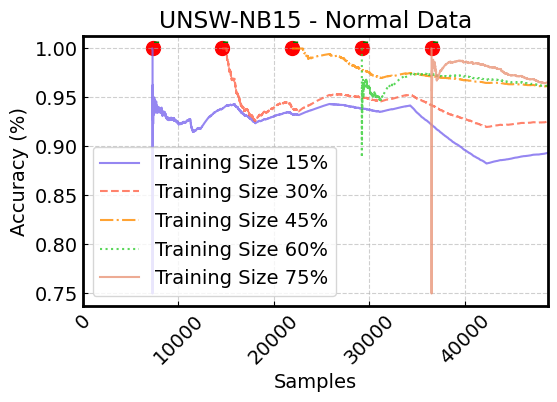

In [ ]:
# Accuracy over differnet training set

# Select a few key training sizes to plot
training_sizes = [15, 30, 45, 60, 75]

plt.figure(figsize=(6, 3.5))
plt.clf()
plt.rcParams.update({'font.size': 14})

# Use a distinct color palette and line styles
#color_palette = ['blue', 'green', 'red', 'purple', 'orange']

color_palette = ['mediumslateblue', 'tomato', 'darkorange', 'limegreen', 'darksalmon']

line_styles = ['-', '--', '-.', ':', '-']

for idx, training_size in enumerate(training_sizes):
    actual_training_size = int(len(X) * training_size / 100)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=actual_training_size, random_state=42, shuffle=False)

    # Original data prediction
    clf = DecisionTreeClassifier(max_depth=10, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)




    acc = []
    acc_sum = 0
    for i in range(0, len(y_test)):
        if y_test[i] == y_pred[i]:
            acc_sum = acc_sum + 1
        accuracy_i = acc_sum / (i + 1)
        acc.append(accuracy_i)

    # Calculate the index where the test set starts
    test_start_index = len(X_train)

    # Plot the accuracy change over time and mark the test set start
    plt.plot(range(test_start_index, len(X_test) + test_start_index), acc[test_start_index - len(X_train):], label=f'Training Size {training_size}%', color=color_palette[idx], linestyle=line_styles[idx], alpha=0.8)

    plt.scatter(test_start_index, acc[0], s=100, c='r', marker='o')
    plt.text(test_start_index, acc[0] + 0.0005, '-', c='g')

plt.legend(loc='lower left')
#plt.title('Accuracy Change over Intrusion Detection Dataset (CICIDS2017)', fontsize=15, fontweight='bold')
plt.xlabel('Samples')
plt.ylabel('Accuracy (%)')

# Rotate x-axis ticks
plt.xticks(rotation=45)

# Increase the border width for spines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set the desired border width
    spine.set_color('black')

# Set ticks inside the plot
ax.tick_params(axis='both', direction='in', which='both', bottom=True, top=False, left=True, right=False)

# ax.spines['bottom'].set_linewidth(2)
# ax.spines['left'].set_linewidth(2)


# Set x-axis limits based on test set size
plt.xlim(0, len(X))

plt.grid(True, linestyle='--', alpha=0.6)
plt.title("UNSW-NB15 - Normal Data")
plt.show()

**6. Accuracy drop with adversarial data**

Decision tree attack:   0%|          | 0/41361 [00:00<?, ?it/s]

Decision tree attack:   0%|          | 0/34062 [00:00<?, ?it/s]

Decision tree attack:   0%|          | 0/26763 [00:00<?, ?it/s]

Decision tree attack:   0%|          | 0/19464 [00:00<?, ?it/s]

Decision tree attack:   0%|          | 0/12165 [00:00<?, ?it/s]

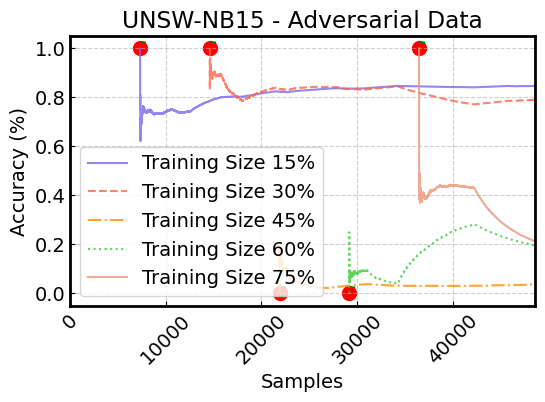

In [ ]:
# Accuracy for adversarial examples over different training set sizes

# Select a few key training sizes to plot
training_sizes = [15, 30, 45, 60, 75]

plt.figure(figsize=(6, 3.5))
plt.clf()
plt.rcParams.update({'font.size': 14})

# Use a distinct color palette and line styles
color_palette = ['mediumslateblue', 'tomato', 'darkorange', 'limegreen', 'darksalmon']
line_styles = ['-', '--', '-.', ':', '-']

for idx, training_size in enumerate(training_sizes):
    actual_training_size = int(len(X) * training_size / 100)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=actual_training_size, random_state=42, shuffle=False)

    # Train the classifier on original data
    clf = DecisionTreeClassifier(max_depth=10, random_state=0)
    clf.fit(X_train, y_train)

    # Attack - Generate adversarial examples
    clf_art = SklearnClassifier(clf)
    attack = DecisionTreeAttack(clf_art, offset=0.00001)
    try:
        adv = attack.generate(X_test)
    except Exception as e:
        print(f"Error generating adversarial examples: {e}")
        continue  # Skip this iteration or handle as needed

    # Predict adversarial examples and calculate accuracy
    y_pred_adv = clf.predict(adv)
    accuracy_adv = accuracy_score(y_test, y_pred_adv)

    acc = []
    acc_sum = 0
    for i in range(0, len(y_test)):
        if y_test[i] == y_pred_adv[i]:
            acc_sum = acc_sum + 1
        accuracy_i = acc_sum / (i + 1)
        acc.append(accuracy_i)

    # Calculate the index where the test set starts
    test_start_index = len(X_train)

    # Plot the adversarial accuracy change over time
    plt.plot(range(test_start_index, len(X_test) + test_start_index), acc[test_start_index - len(X_train):],
             label=f'Training Size {training_size}%', color=color_palette[idx], linestyle=line_styles[idx], alpha=0.8)

    plt.scatter(test_start_index, acc[0], s=100, c='r', marker='o')
    plt.text(test_start_index, acc[0] + 0.0005, '-', c='g')

plt.legend(loc='lower left')
plt.xlabel('Samples')
plt.ylabel('Accuracy (%)')

# Rotate x-axis ticks
plt.xticks(rotation=45)

# Increase the border width for spines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set the desired border width
    spine.set_color('black')

# Set ticks inside the plot
ax.tick_params(axis='both', direction='in', which='both', bottom=True, top=False, left=True, right=False)

# Set x-axis limits based on test set size
plt.xlim(0, len(X))

plt.grid(True, linestyle='--', alpha=0.6)
plt.title("UNSW-NB15 - Adversarial Data")
plt.show()


**General Adversarial Method**

In [ ]:
# Preprocessing
X = df.iloc[:, df.columns != 'Label'].values  # Convert to NumPy array
y = df[['Label']].to_numpy()

# Label encoding
le = preprocessing.LabelEncoder().fit(y)
y = le.transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state=0, shuffle=True)

# DTC Classifier
clf = DecisionTreeClassifier(max_depth=10, random_state=0) # max_depth=10
clf.fit(X_train, y_train)

clf_art = SklearnClassifier(clf)

# Select 50 entries from index 10000 to 10050 for testing
# X_test = X[10000:11000]
# y_test = y[10000:11000]


# Make predictions on the original (non-adversarial) data
y_pred_original = clf.predict(X_test)

print("clf features importance")
feature_importances_original = clf.feature_importances_
print(feature_importances_original)

# Evaluate the model performance on the original data
accuracy_original = accuracy_score(y_test, y_pred_original)
precision_original = precision_score(y_test, y_pred_original, average='weighted')
recall_original = recall_score(y_test, y_pred_original, average='weighted')
f1_original = f1_score(y_test, y_pred_original, average='weighted')

print(f"Original Model Performance:")
print(f"Accuracy: {accuracy_original:.4f}")
print(f"Precision: {precision_original:.4f}")
print(f"Recall: {recall_original:.4f}")
print(f"F1 Score: {f1_original:.4f}")

# Attack - Generate adversarial examples
attack = DecisionTreeAttack(clf_art, offset=0.001)
adv = attack.generate(X_test)

# Make predictions on the adversarial data
y_pred_adv = clf.predict(adv)

print("adv features importance")
feature_importances_adv = clf.feature_importances_
print(feature_importances_adv)

# Evaluate the model performance on the adversarial data
accuracy_adv = accuracy_score(y_test, y_pred_adv)
precision_adv = precision_score(y_test, y_pred_adv, average='weighted')
recall_adv = recall_score(y_test, y_pred_adv, average='weighted')
f1_adv = f1_score(y_test, y_pred_adv, average='weighted')

print(f"\nAdversarial Model Performance - degraded performance due to adversarial (modified) samples:")
print(f"Accuracy: {accuracy_adv:.4f}")
print(f"Precision: {precision_adv:.4f}")
print(f"Recall: {recall_adv:.4f}")
print(f"F1 Score: {f1_adv:.4f}")

# print("\n Original data prediction    : ", y_pred_original)
# print("\n Adversarial data prediction : ", y_pred_adv)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


clf features importance
[0.04001567 0.41556827 0.07987107 0.43976384 0.02478115]
Original Model Performance:
Accuracy: 0.9842
Precision: 0.9842
Recall: 0.9842
F1 Score: 0.9841


Decision tree attack:   0%|          | 0/17070 [00:00<?, ?it/s]

adv features importance
[0.04001567 0.41556827 0.07987107 0.43976384 0.02478115]

Adversarial Model Performance - degraded performance due to adversarial (modified) samples:
Accuracy: 0.0158
Precision: 0.0145
Recall: 0.0158
F1 Score: 0.0134


**7. Calculate the feature importance over segments**

Segment ID: 1
Accuracy: 0.9588514582862311
Selected Features: ['sport', 'dsport', 'totalHeaderSize', 'max_pkt_size', 'mean_pkt_size']
Segment ID: 2
Accuracy: 0.9400859145376441
Selected Features: ['sport', 'dsport', 'totalHeaderSize', 'max_pkt_size', 'mean_pkt_size']
Segment ID: 3
Accuracy: 0.9470947320822971
Selected Features: ['sport', 'dsport', 'totalHeaderSize', 'max_pkt_size', 'mean_pkt_size']
Segment ID: 4
Accuracy: 0.9918607280126611
Selected Features: ['sport', 'dsport', 'totalHeaderSize', 'max_pkt_size', 'mean_pkt_size']
Segment ID: 5
Accuracy: 0.9321727334388424
Selected Features: ['sport', 'dsport', 'totalHeaderSize', 'max_pkt_size', 'mean_pkt_size']
Segment ID: 6
Accuracy: 0.973999547818223
Selected Features: ['sport', 'dsport', 'totalHeaderSize', 'max_pkt_size', 'mean_pkt_size']
Segment ID: 7
Accuracy: 0.9479990956364458
Selected Features: ['sport', 'dsport', 'totalHeaderSize', 'max_pkt_size', 'mean_pkt_size']
Segment ID: 8
Accuracy: 0.9615645489486774
Selected Features: [

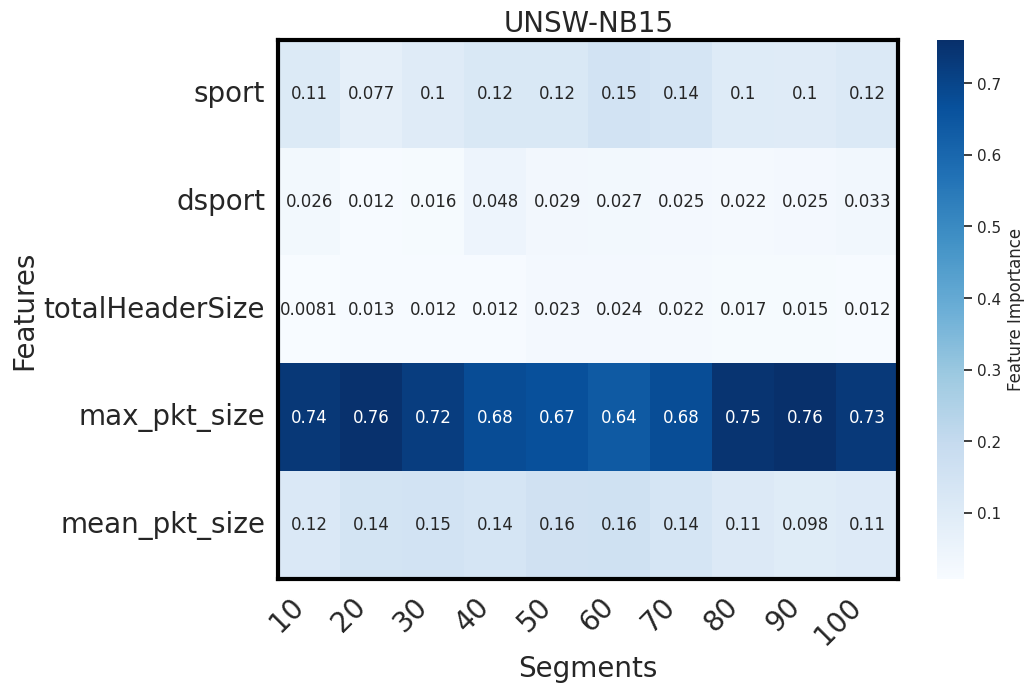

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a Pandas DataFrame named "dfff" with a "Label" column as the target variable
# df = dataset.csv

# Split your data into 12 segments
n_segments = 11
segment_size = len(df) // n_segments

# Initialize lists to store true and predicted labels for confusion matrices
all_y_true = []
all_y_pred = []

# Initialize a list to store feature importances for each iteration
all_feature_importances = []

# Initialize a SelectKBest feature selector to select the top 5 features
selector = SelectKBest(score_func=f_classif, k=5)

for segment in range(1, n_segments):  # Start from the second segment
    # Accumulate data until the current segment
    train_start = 0
    train_end = (segment + 1) * segment_size
    X_train = df.iloc[train_start:train_end].drop(columns=['Label'])
    y_train = df.iloc[train_start:train_end]['Label']

    # Train the model on the accumulated training data
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Split the data into testing and validation segments
    test_start = (segment + 1) * segment_size
    test_end = (segment + 2) * segment_size
    X_test = df.iloc[test_start:test_end].drop(columns=['Label'])
    y_test = df.iloc[test_start:test_end]['Label']

    # Make predictions on the test segment
    y_pred = clf.predict(X_test)

    # Calculate accuracy for this segment
    accuracy = accuracy_score(y_test, y_pred)
    print("Segment ID:", segment)
    print("Accuracy:", accuracy)

    # Append true and predicted labels to the lists
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # Calculate feature importances for this iteration
    segment_feature_importances = clf.feature_importances_
    all_feature_importances.append(segment_feature_importances)

    # Perform feature selection for this segment
    selector.fit(X_train, y_train)
    selected_feature_indices = selector.get_support(indices=True)
    selected_feature_names = X_train.columns[selected_feature_indices]
    print("Selected Features:", selected_feature_names.tolist())

# Calculate and print the mean accuracy across all segments
mean_accuracy = accuracy_score(all_y_true, all_y_pred)
print("Mean Accuracy Across All Segments:", mean_accuracy)

# Prepare data for the heatmap
feature_labels = X_train.columns
feature_importances = np.array(all_feature_importances).T  # Transpose for correct alignment

# Set Seaborn style and color palette
sns.set(style="whitegrid")
plt.figure(figsize=(10, 7))

# Create a heatmap of feature importances with the specified color palette
heatmap = sns.heatmap(feature_importances, annot=True, cmap='Blues', xticklabels=[str(i*10) for i in range(1, n_segments)], yticklabels=feature_labels, cbar_kws={'label': 'Feature Importance'})
plt.xlabel("Segments", fontsize=20)
plt.ylabel("Features", fontsize=20)
plt.xticks(rotation=45, ha='right')  # Align x-axis labels to the right
plt.yticks(rotation=0)  # Keep y-axis labels horizontal

# Set the font size of x-axis and y-axis tick labels
heatmap.tick_params(axis='both', labelsize=20)

# Access the Axes object from the heatmap
ax = heatmap.axes

# Set spines width and color
for spine in ax.spines.values():
    spine.set_linewidth(3)  # Set the desired border width
    spine.set_color('black')  # Set the desired border color
    spine.set_visible(True)  # Ensure the spines are visible

# Set the background color of the entire plot
ax.set_facecolor('none')

plt.title("UNSW-NB15", fontsize=20)
plt.show()
plt.show()